In [1]:
!pip install pyspark==3.5.0 delta-spark==3.1.0 matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425346 sha256=57d1a64f09f76a947fd1f424772e77191056523959ec1e6806d7c6f1ce03acf2
  Stored in directory: /root/.cache/pip/wheels/38/df/61/8c121f50c3cffd77f8178180dd232d90b3b99d1bd61fb6d6be
Successfully built pyspark
  Attempting uninstall: pyspark
    Found existing installation: pyspark 3.5.1
    Uninstalling pyspark-3.5.1:
      Successfully uninstalled pyspark-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-spark-connect 0.8.3 requires pyspark[connect]~=3.5.1, but you have pyspark 3.5.0 which is incompatible.


In [2]:
from pyspark.sql import SparkSession
from delta import configure_spark_with_delta_pip
from pyspark.sql import functions as F, types as T
import matplotlib.pyplot as plt
import time
builder = (
    SparkSession.builder.appName("DeltaRideHailing")
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
)
spark = configure_spark_with_delta_pip(builder).getOrCreate()

# Seeding Data


In [5]:
from pyspark.sql import SparkSession
from delta import configure_spark_with_delta_pip
from pyspark.sql import functions as F, types as T
import matplotlib.pyplot as plt
import time
from datetime import datetime

builder = (
    SparkSession.builder.appName("DeltaRideHailing")
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
)
spark = configure_spark_with_delta_pip(builder).getOrCreate()

trip_schema = T.StructType([
    T.StructField("trip_id", T.IntegerType()),
    T.StructField("rider_id", T.StringType()),
    T.StructField("driver_id", T.StringType()),
    T.StructField("city", T.StringType()),
    T.StructField("distance_km", T.DoubleType()),
    T.StructField("fare", T.DoubleType()),
    T.StructField("tip", T.DoubleType()),
    T.StructField("ts", T.TimestampType())
])

driver_schema = T.StructType([
    T.StructField("driver_id", T.StringType()),
    T.StructField("driver_name", T.StringType()),
    T.StructField("rating", T.DoubleType()),
    T.StructField("vehicle", T.StringType())
])

trips_rows = [
    (1001, "R001", "D010", "Bengaluru", 12.4, 320.0, 20.0, datetime.strptime("2025-08-08 08:05:00", "%Y-%m-%d %H:%M:%S")),
    (1002, "R002", "D011", "Hyderabad", 6.2, 150.0, 10.0, datetime.strptime("2025-08-08 08:15:00", "%Y-%m-%d %H:%M:%S")),
    (1003, "R003", "D012", "Pune", 3.5, 90.0, 0.0, datetime.strptime("2025-08-08 08:20:00", "%Y-%m-%d %H:%M:%S")),
    (1004, "R001", "D010", "Bengaluru", 18.9, 480.0, 25.0, datetime.strptime("2025-08-08 08:45:00", "%Y-%m-%d %H:%M:%S")),
    (1005, "R004", "D013", "Chennai", 10.0, 260.0, 15.0, datetime.strptime("2025-08-08 09:05:00", "%Y-%m-%d %H:%M:%S")),
    (1006, "R005", "D012", "Pune", 2.2, 70.0, 0.0, datetime.strptime("2025-08-08 09:10:00", "%Y-%m-%d %H:%M:%S")),
]

drivers_rows = [
    ("D010", "Anil", 4.8, "WagonR"),
    ("D011", "Sana", 4.6, "i20"),
    ("D012", "Rakesh", 4.4, "Swift"),
    ("D013", "Meera", 4.9, "Ciaz"),
]

trips_df = spark.createDataFrame(trips_rows, schema=trip_schema)
drivers_df = spark.createDataFrame(drivers_rows, schema=driver_schema)

BASE = "/tmp/delta/ride_hailing"
TRIPS_PATH = f"{BASE}/trips"
DRIVERS_PATH = f"{BASE}/drivers"

trips_df.write.format("delta").mode("overwrite").save(TRIPS_PATH)
drivers_df.write.format("delta").mode("overwrite").save(DRIVERS_PATH)

# Managed vs Unmanaged

In [6]:
spark.sql(f"CREATE TABLE trips_managed USING DELTA AS SELECT * FROM delta.`{TRIPS_PATH}`")
spark.sql(f"CREATE TABLE drivers_ext USING DELTA LOCATION '{DRIVERS_PATH}'")

print("Managed Table Detail:")
spark.sql("DESCRIBE DETAIL trips_managed").show(truncate=False)
print("Unmanaged Table Detail:")
spark.sql("DESCRIBE DETAIL drivers_ext").show(truncate=False)


Managed Table Detail:
+------+------------------------------------+-----------------------------------+-----------+-------------------------------------------+-----------------------+----------------------+----------------+--------+-----------+----------+----------------+----------------+------------------------+
|format|id                                  |name                               |description|location                                   |createdAt              |lastModified          |partitionColumns|numFiles|sizeInBytes|properties|minReaderVersion|minWriterVersion|tableFeatures           |
+------+------------------------------------+-----------------------------------+-----------+-------------------------------------------+-----------------------+----------------------+----------------+--------+-----------+----------+----------------+----------------+------------------------+
|delta |52a1c631-f484-4486-81b7-84516c5e18c5|spark_catalog.default.trips_managed|NULL       |file:/

# 2.Read & Explore

In [7]:
df_trips = spark.read.format("delta").load(TRIPS_PATH)
df_drivers = spark.read.format("delta").load(DRIVERS_PATH)
df_trips.printSchema()
df_drivers.printSchema()
df_trips.show(10)

df_trips.withColumn("total_amount", F.col("fare") + F.col("tip"))\
    .orderBy(F.desc("total_amount")).show(5)

root
 |-- trip_id: integer (nullable = true)
 |-- rider_id: string (nullable = true)
 |-- driver_id: string (nullable = true)
 |-- city: string (nullable = true)
 |-- distance_km: double (nullable = true)
 |-- fare: double (nullable = true)
 |-- tip: double (nullable = true)
 |-- ts: timestamp (nullable = true)

root
 |-- driver_id: string (nullable = true)
 |-- driver_name: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- vehicle: string (nullable = true)

+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|   1004|    R001|     D010|Bengaluru|       18.9|480.0|25.0|2025-08-08 08:45:00|
|   1005|    R004|     D013|  Chennai|       10.0|260.0|15.0|2025-08-08 09:05:00|
|   1006|    R005|     D012|     Pune|        2.2| 70.0| 0.0|2025-08-08 09:10:00|
|   1001|    R001|     D010

# 3. Update




In [8]:
from delta.tables import DeltaTable
dt = DeltaTable.forPath(spark, TRIPS_PATH)
print("Before Update:")
dt.update(
    condition="city='Bengaluru' AND distance_km > 15",
    set={"tip": F.col("tip") + 5}
)
print("After Update:")
dt.toDF().filter("city='Bengaluru' AND distance_km > 15").show()


Before Update:
After Update:
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|   1004|    R001|     D010|Bengaluru|       18.9|480.0|30.0|2025-08-08 08:45:00|
+-------+--------+---------+---------+-----------+-----+----+-------------------+



# 4.Delete Bad Data

In [9]:
dt.delete("fare <= 0 OR distance_km <= 0")
print("Row Count After Delete:", dt.toDF().count())

Row Count After Delete: 6


# 5. Merge

In [12]:
from datetime import datetime

new_batch = [
    (1004, "R001", "D010", "Bengaluru", 18.9, 500.0, 30.0, datetime.strptime("2025-08-08 08:45:00", "%Y-%m-%d %H:%M:%S")),
    (1007, "R006", "D013", "Chennai", 8.5, 210.0, 10.0, datetime.strptime("2025-08-08 09:20:00", "%Y-%m-%d %H:%M:%S")),
]
new_df = spark.createDataFrame(new_batch, schema=trip_schema)

dt.alias("t").merge(
    new_df.alias("n"),
    "t.trip_id = n.trip_id"
).whenMatchedUpdateAll().whenNotMatchedInsertAll().execute()

dt.toDF().filter("trip_id IN (1004,1007)").show()

+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|   1004|    R001|     D010|Bengaluru|       18.9|500.0|30.0|2025-08-08 08:45:00|
|   1007|    R006|     D013|  Chennai|        8.5|210.0|10.0|2025-08-08 09:20:00|
+-------+--------+---------+---------+-----------+-----+----+-------------------+



#6. Gold View & KPIs


In [13]:
gold_df = dt.toDF().join(df_drivers, "driver_id") \
    .withColumn("total_amount", F.col("fare") + F.col("tip")) \
    .select("trip_id", "city", "driver_name", "rating", "distance_km", "total_amount", "ts")

gold_df.createOrReplaceTempView("gold_view")

# City-wise total revenue and avg driver rating
spark.sql("""
SELECT city, SUM(total_amount) AS total_revenue, AVG(rating) AS avg_rating
FROM gold_view
GROUP BY city
""").show()

# Driver-wise total trips & top 3 drivers by revenue
spark.sql("""
SELECT driver_name, COUNT(*) AS total_trips, SUM(total_amount) AS total_revenue
FROM gold_view
GROUP BY driver_name
ORDER BY total_revenue DESC
LIMIT 3
""").show()

+---------+-------------+----------+
|     city|total_revenue|avg_rating|
+---------+-------------+----------+
|  Chennai|        495.0|       4.9|
|     Pune|        160.0|       4.4|
|Bengaluru|        870.0|       4.8|
|Hyderabad|        160.0|       4.6|
+---------+-------------+----------+

+-----------+-----------+-------------+
|driver_name|total_trips|total_revenue|
+-----------+-----------+-------------+
|       Anil|          2|        870.0|
|      Meera|          2|        495.0|
|     Rakesh|          2|        160.0|
+-----------+-----------+-------------+



#7.Time Travel

In [14]:
print("History:")
dt.history().show()

print("As of Version 0:")
dt.toDF().show()
version0_df = spark.read.format("delta").option("versionAsOf", 0).load(TRIPS_PATH)
version0_df.show()
print("Count difference:", version0_df.count(), "→", dt.toDF().count())


History:
+-------+--------------------+------+--------+---------+--------------------+----+--------+---------+-----------+--------------+-------------+--------------------+------------+--------------------+
|version|           timestamp|userId|userName|operation| operationParameters| job|notebook|clusterId|readVersion|isolationLevel|isBlindAppend|    operationMetrics|userMetadata|          engineInfo|
+-------+--------------------+------+--------+---------+--------------------+----+--------+---------+-----------+--------------+-------------+--------------------+------------+--------------------+
|      2|2025-08-15 05:48:...|  NULL|    NULL|    MERGE|{predicate -> ["(...|NULL|    NULL|     NULL|          1|  Serializable|        false|{numTargetRowsCop...|        NULL|Apache-Spark/3.5....|
|      1|2025-08-15 05:46:...|  NULL|    NULL|   UPDATE|{predicate -> ["(...|NULL|    NULL|     NULL|          0|  Serializable|        false|{numRemovedFiles ...|        NULL|Apache-Spark/3.5....|
|

# 8.Partitioned Rewrite

In [15]:
PARTITIONED_PATH = f"{BASE}/trips_partitioned"
dt.toDF().write.format("delta").mode("overwrite").partitionBy("city").save(PARTITIONED_PATH)
spark.read.format("delta").load(PARTITIONED_PATH).filter("city='Bengaluru'").show()


+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|   1004|    R001|     D010|Bengaluru|       18.9|500.0|30.0|2025-08-08 08:45:00|
|   1001|    R001|     D010|Bengaluru|       12.4|320.0|20.0|2025-08-08 08:05:00|
+-------+--------+---------+---------+-----------+-----+----+-------------------+



# 9. Incremental Load

In [18]:
from datetime import datetime

inc_batch = [
    (1008, "R007", "D010", "Mumbai", 9.2, 300.0, 20.0, datetime.strptime("2025-08-08 10:00:00", "%Y-%m-%d %H:%M:%S")),
    (1009, "R008", "D011", "Mumbai", 5.5, 180.0, 15.0, datetime.strptime("2025-08-08 10:15:00", "%Y-%m-%d %H:%M:%S")),
]
spark.createDataFrame(inc_batch, schema=trip_schema).write.format("delta").mode("append").save(TRIPS_PATH)
spark.read.format("delta").load(TRIPS_PATH).groupBy("city").agg(F.sum(F.col("fare") + F.col("tip")).alias("revenue")).show()

+---------+-------+
|     city|revenue|
+---------+-------+
|  Chennai|  495.0|
|     Pune|  160.0|
|Bengaluru|  870.0|
|Hyderabad|  160.0|
|   Mumbai|  515.0|
+---------+-------+



# 10.Simple Streaming

In [21]:
from datetime import datetime

stream_df = spark.readStream.format("delta").load(TRIPS_PATH)
query = stream_df.writeStream.format("console").outputMode("append").trigger(processingTime="5 seconds").start()

# Append one more trip after short wait
time.sleep(5)
extra_trip = [(1010, "R009", "D013", "Mumbai", 7.5, 220.0, 10.0, datetime.strptime("2025-08-08 10:30:00", "%Y-%m-%d %H:%M:%S"))]
spark.createDataFrame(extra_trip, schema=trip_schema).write.format("delta").mode("append").save(TRIPS_PATH)

time.sleep(10)
query.stop()

# 11.Visualization

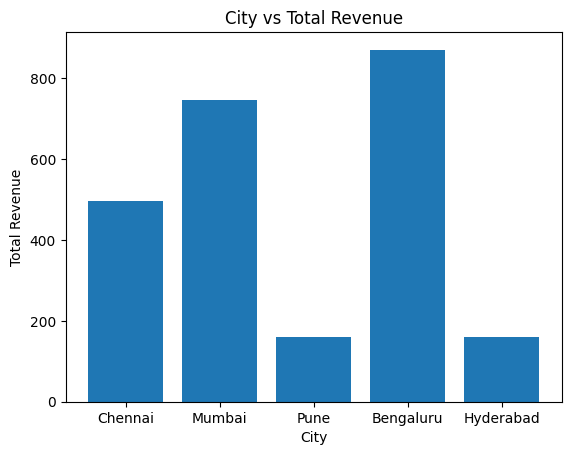

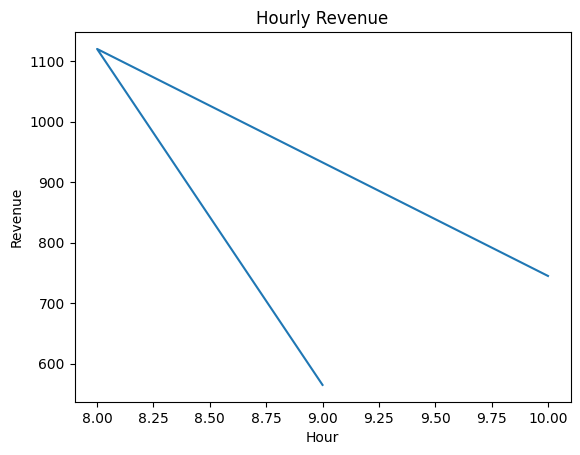

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

city_revenue = gold_df.groupBy("city").agg(F.sum("total_amount").alias("total_revenue")).toPandas()
plt.bar(city_revenue["city"], city_revenue["total_revenue"])
plt.xlabel("City")
plt.ylabel("Total Revenue")
plt.title("City vs Total Revenue")
plt.show()

hourly_revenue = gold_df.withColumn("hour", F.hour("ts")) \
    .groupBy("hour").agg(F.sum("total_amount").alias("total_revenue")).toPandas()
plt.plot(hourly_revenue["hour"], hourly_revenue["total_revenue"])
plt.xlabel("Hour")
plt.ylabel("Revenue")
plt.title("Hourly Revenue")
plt.show()


# 12  Managed vs Unmanaged Cleanup

In [23]:
spark.sql("DROP TABLE trips_managed")
spark.sql("DROP TABLE drivers_ext")
import os
print("Managed path exists?", os.path.exists(TRIPS_PATH))
print("Unmanaged path exists?", os.path.exists(DRIVERS_PATH))


Managed path exists? True
Unmanaged path exists? True


#13.Constraint Check

In [26]:
from datetime import datetime

bad_data = [(1011, "R010", "D010", "Bengaluru", 5.0, 100.0, -5.0, datetime.strptime("2025-08-08 11:00:00", "%Y-%m-%d %H:%M:%S"))]
bad_df = spark.createDataFrame(bad_data, schema=trip_schema)
bad_df_filtered = bad_df.filter("tip >= 0")
bad_df_filtered.write.format("delta").mode("append").save(TRIPS_PATH)
print("Bad data rejected, only valid rows written.")

Bad data rejected, only valid rows written.


#14.Convert Parquet → Delta

In [27]:
PARQUET_PATH = f"{BASE}/trips_parquet"
subset_df = dt.toDF().limit(2)
subset_df.write.mode("overwrite").parquet(PARQUET_PATH)
spark.sql(f"CONVERT TO DELTA parquet.`{PARQUET_PATH}`")
spark.read.format("delta").load(PARQUET_PATH).show()

+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|   1004|    R001|     D010|Bengaluru|       18.9|500.0|30.0|2025-08-08 08:45:00|
|   1005|    R004|     D013|  Chennai|       10.0|260.0|15.0|2025-08-08 09:05:00|
+-------+--------+---------+---------+-----------+-----+----+-------------------+



#15  KPI Dashboard

Total Revenue: 2430.0


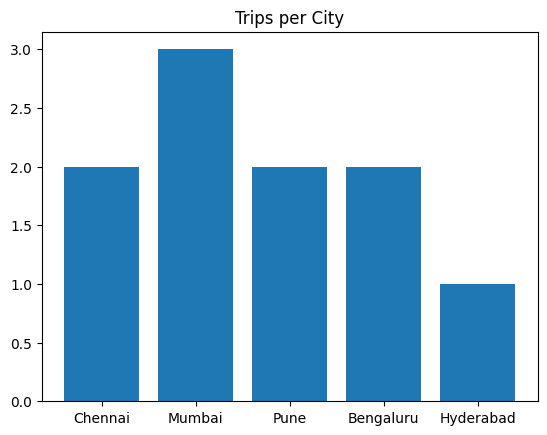

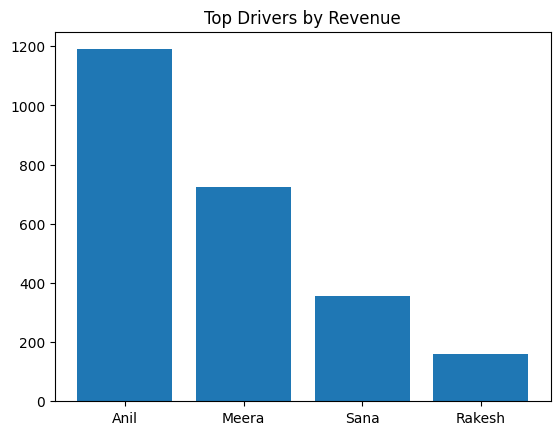

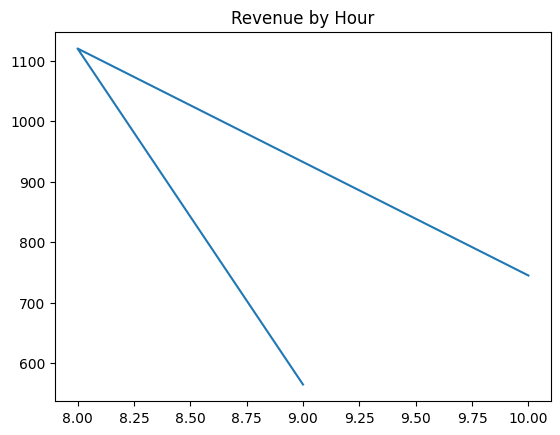

In [28]:
total_revenue = gold_df.agg(F.sum("total_amount")).collect()[0][0]
print("Total Revenue:", total_revenue)

trips_per_city = gold_df.groupBy("city").count().toPandas()
plt.bar(trips_per_city["city"], trips_per_city["count"])
plt.title("Trips per City")
plt.show()

top_drivers = gold_df.groupBy("driver_name").agg(F.sum("total_amount").alias("total_revenue")).orderBy(F.desc("total_revenue")).toPandas()
plt.bar(top_drivers["driver_name"], top_drivers["total_revenue"])
plt.title("Top Drivers by Revenue")
plt.show()

revenue_by_hour = gold_df.withColumn("hour", F.hour("ts")).groupBy("hour").agg(F.sum("total_amount").alias("total_revenue")).toPandas()
plt.plot(revenue_by_hour["hour"], revenue_by_hour["total_revenue"])
plt.title("Revenue by Hour")
plt.show()